In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_boston
%matplotlib inline

#boston 데이터 세트 로드
boston = load_boston()

#boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

#boston 데이터 세트의 target 배열은 주택 가격임, 이를 PRICE 칼럼으로 DataFrame 추가
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기: ',bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기:  (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train,X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 1. 릿지 회귀

선형모델의 비용 함수는 RSS를 최소화하는, 실제값과 예측값의 차이를 최소하는 것만 고려   
=> 학습 데이터 지나치게 맞추고, 회귀 계수 커짐   
=> 테스트 데이터 예측 성능 저하   
=> 비용함수는 학습데이터의 잔차 오류 값을 최소로 하는 RSS 최소화 방법과 과적합 방지위해 회귀 계수 커지면 안됨   

- 비용 함수 목표 = Min(RSS(W) + alpha * ||W||)   
(alpha:학습 데이터 적합 정도, 회귀 계수값 크기 제어하는 튜닝 파라미터)   
(alpha 크게 하면 과적합 개선 가능, 작게하면 학습데이터 적합을 개선)

- alpha를 0 에서 부터 지속적으로 증가시키면 회귀계수 값의 크기 감소.

- 규제: 회귀 계수 값의 크기를 감소시켜 과적합 개선 시키는 것

    1. L2규제: ||W||제곱에 패널티를 부여 -->릿지 회귀
    2. L1규제: ||W||에 패널티 부여

In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

In [9]:
print('5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores,3))
print('5 folds 의 개별 RMSE scores: ',np.round(rmse_scores,3))
print('5 folds 의 평균 RMSE: {0:.3f} '.format(avg_rmse))

# 앞 예제의 규제가 없는 LinearRegression의 RMSE 펴균보다 더 뛰어난 예측 성능 보임

5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds 의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
5 folds 의 평균 RMSE: 5.518 


- 릿지의 alpha 값을 0, 0.1, 1, 10, 100으로 변화시키면서 RMSE와 회귀 계수 값의 변화를 살펴보자
- 릿지 회귀는 alpha 값이 커질수록 회귀 계수 값을 작게 만듦

In [10]:
# 릿지에 사용될 alpha 파라미터 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alpha list 값을 반복하면서 alpha에 따른 평균 rmse를 구함
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    
    # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0}일 때 5 folds의 평균 RMSE: {1:.3f}'.format(alpha,avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE: 5.829
alpha 0.1일 때 5 folds의 평균 RMSE: 5.788
alpha 1일 때 5 folds의 평균 RMSE: 5.653
alpha 10일 때 5 folds의 평균 RMSE: 5.518
alpha 100일 때 5 folds의 평균 RMSE: 5.330


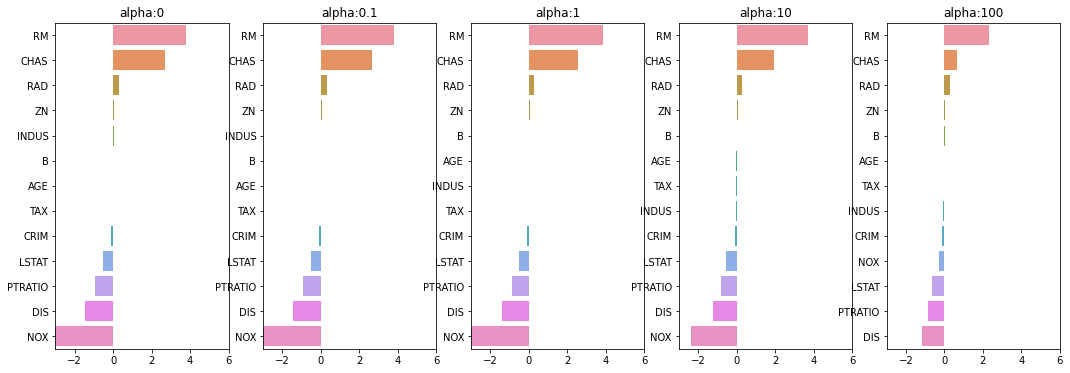

In [13]:
# alpha값의 변화에 따른 피처의 회귀 계수 값 (막대 그래프)

# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    
    # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼 추가
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화, 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])
    
# for 문 바깥에서 맥플롯립의 show호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

# alpha값이 커질수록 회귀계수가 점점 작아지고 있다는 것을 볼 수 있음
# 특히 NOX값의 차이가 크다

In [19]:
ridge_alphas = [0, 0.1, 1, 10 ,100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column,ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


# 2. 라쏘 회귀

- 라쏘 회귀: W의 절댓값에 패널티를 부여하는 L1 규제를 선형 회귀에 적용한 것

- L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거(적절한 피처만 회귀에 포함시킴)

In [22]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 변환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True): # verbose:상세한 진행 설명보여줌
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name, ' #######')
    for param in params:
        if model_name == 'Ridge': model = Ridge(alpha=param)
        elif model_name == 'Lasso': model = Lasso(alpha=param)
        elif model_name == 'ElasticNet' : model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mas_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0}일 때 5폴드 세트의 평균 RMSE: {1:.3f}'.format(param,avg_rmse))
        
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data, y_target)
        
        # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
        coeff = pd.Series(data=model.coef_,index= X_data.columns)
        colname = 'alpha:'+str(param)
        coeff_df[colname] = coeff
        
    return coeff_df
# end of get_linear_regre_eval   

In [23]:
# 라쏘에 사용될 alpha 파라미터 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1,3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso  #######
alpha 0.07일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 0.1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 0.5일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 3일 때 5폴드 세트의 평균 RMSE: 5.330


In [24]:
# 반환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:' + str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

# alpha값이 커질 수록 0 값으로 된것이 많다는 것을 볼 수 있음
# 회귀 계수가 0 인 피처는 회귀식에서 제외되면서 피처 선택의 효과 얻을 수 있음

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


# 3. 엘라스틱넷 회귀

- 엘라스틱넷 회귀 : L2 규제와 L1규제를 결합한 회귀 (-> 두가지 하느라 시간 오래 걸림)
- RSS(W) +alpha2*|W|^2 + alpha1*|W| 식을 최소화하는 W 찾는 것   
    - a**L1 + b* *L2 (a:L1규제의 alpha값, b:L2규제의 alpha값)(alpha파라미터 값: a+b)

In [25]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# li_ratio 는 0.7로 고정  -> alpha값의 변화만 살피기 위함
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet  #######
alpha 0.07일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 0.1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 0.5일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 3일 때 5폴드 세트의 평균 RMSE: 5.330


In [26]:
# 반환된 coeff_elastic_df를 첫번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:' + str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


- 어떤 것이 좋은지는 상황에 따라 다름
- 각각의 알고리즘에서 하이퍼 파라미터를 변경해 가면서 최적의 예측 성능 찾아야 함

# 4. 선형 회귀 모델을 위한 데이터 변환

피처값, 타겟값 왜곡된 형태의 분포도이면 예측 성능에 부정적인 영향 미칠 수 있음   
=> 스케일링/정규화 작업 수행(무조건 예측 성능 향상되는건 아님)

   1. StandardScaler 클래스를 이용해 평균이 0, 분산이 1인 표준정규분포를 가진 데이터 세트로 변환하거나 MinMaxScaler 클래스를 이용해 최솟값이0, 최댓값이 1인값으로 정규화 수행

   2. (1번 방법통해 예측 성능에 향상이 없을 경우) 스케일링/정규화를 수행한 데이터 세트에 다항 특성을 적용하여 변환

   3. 원래 값에 log를 적용하면 보다 정규 분포에 가까운 형태로 분포.(타깃갑의 경우 로그변환 적용 많이 함)

In [28]:
# method는 표준 정규 분포 변환, 최댓값/최솟값 정규화, 로그변환 결정
# p_degree는 다항식 특성을 추가할 때 적용, p_degree는 2이상 부여X
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
        
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

    
    return scaled_data

In [29]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas=[0.1, 1, 10,100]

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

# 5개 방식으로 변환 [원본 그대로, 표준정규 분포, 표준정규분포+다항식 특성, 최대최소 정규화, 최대최소 정규화+다항식 특성, 로그변환]
scale_methods =[(None,None), ('Standard',None), ('Standard',2), ('MinMax',None), ('MinMax',2), ('Log',None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
    print('\n## 변환 유형: {0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge',params=alphas, X_data_n = X_data_scaled, y_target_n=y_target, verbose=False)


## 변환 유형: None, Polynomial Degree:None
alpha 0.1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 10일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 100일 때 5폴드 세트의 평균 RMSE: 5.330

## 변환 유형: Standard, Polynomial Degree:None
alpha 0.1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 10일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 100일 때 5폴드 세트의 평균 RMSE: 5.330

## 변환 유형: Standard, Polynomial Degree:2
alpha 0.1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 10일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 100일 때 5폴드 세트의 평균 RMSE: 5.330

## 변환 유형: MinMax, Polynomial Degree:None
alpha 0.1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 10일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 100일 때 5폴드 세트의 평균 RMSE: 5.330

## 변환 유형: MinMax, Polynomial Degree:2
alpha 0.1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 10일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 100일 때 5폴드 세트의 평균 RMSE: 5.330

## 변환 유형: Log, Polynomial Degree:None
alpha 0.1일 때 5폴드 세트의 평균 RMSE: 5.330
alpha 1일 때 5폴드

결과: 표준정규분포, 최솟값/최댓값 정규화는 성능상 개선 X

- 2차 다항식 변환하면 성능 개선있지만 피처가 많을 때 적용하기 힘들고 시간이 많이 소모됨

- 로그변환을 보면 모든 alpha값에 대해 좋은 성능 향상 => 로그 변환이 젤 적합